In [12]:
import numpy as np 
import math 
import matplotlib.pylab as plt
from sklearn.metrics import mean_squared_error

## 数据准备部分

In [3]:
def shuffle_data(X,y,seed=None):
    "将X和y的数据进行随机排序/乱序化"
    if seed:
        np.random.seed(seed)
    idx=np.arange(X.shape[0])
    print(type(idx))
    np.random.shuffle(idx)
    return X[idx],y[idx] #对于np.array，idx作为index数组可以改变array的顺序

In [4]:
x=[0,1,2,3,4,5]
np.random.shuffle(x)
x

[4, 5, 0, 3, 2, 1]

In [5]:
a=np.array([12,3])
a[np.array([1,0])] #翻滚

array([ 3, 12])

In [6]:
shuffle_data(np.array([12,3,1]), np.array([1,2,3]))

<class 'numpy.ndarray'>


(array([12,  1,  3]), array([1, 3, 2]))

In [7]:
def train_test_split(X,y,test_size=0.5,shuffle=True,seed=None):
    '将数据集根据test_size分成训练集和测试集，可以指定是否随机洗牌'
    if shuffle:
        X,y=shuffle_data(X,y,seed)
    split_i=len(y)-int(len(y)//(1/test_size)) #//号保留它的int值
    #split_i=len(y)-int(len(y)*test_size)
    #分割点确定X，y都确定
    X_train,X_test=X[:split_i],X[split_i:]
    y_train,y_test=y[:split_i],y[split_i:]
    
    return X_train, X_test, y_train, y_test

In [8]:
from sklearn.datasets import make_regression

In [9]:
#make_regression的数据
X,y=make_regression(n_samples=100,n_features=1,noise=20)

In [10]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

<class 'numpy.ndarray'>


`注意`：因为使用train_test_split函数使得X乱序，在matplot绘制图像时会有问题，所以对于X进行排序

乱序花plot时，不是从小到大来画，折线，到处都是一个点

评测集做排序

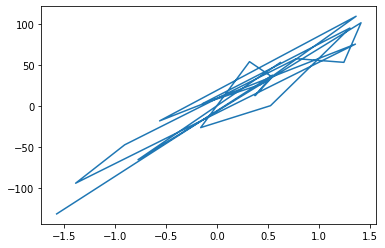

In [11]:
plt.plot(X_test,y_test)

In [13]:
# 只排列test即可
s=sorted([(X_test[i][0], y_test[i]) for i in range(len(X_test))],key=lambda j:j[0])

In [14]:
s

[(-1.5714998476944846, -131.04367033539882),
 (-1.3859261882195588, -93.60922490234569),
 (-0.9058293853123284, -46.82647764830192),
 (-0.7748308990830076, -64.93070281473499),
 (-0.5636161626225747, -17.63342346132815),
 (-0.16158801768459224, -25.84828113880006),
 (-0.14399454133262268, 3.328948606065296),
 (0.31666736121885397, 54.55863304129922),
 (0.3705369823345305, 13.094438388527958),
 (0.42655243070263527, 26.730092304904865),
 (0.5224203020545581, 0.9068422926611959),
 (0.539490674855146, 35.78792578662397),
 (0.5409304592109262, 38.126123451757884),
 (0.6181208668574665, 53.52809607762425),
 (0.7751609192233712, 58.20603635525426),
 (1.2405376172537221, 53.718874121271746),
 (1.2995810607249982, 95.52025126381423),
 (1.3538115149528362, 75.94077855564103),
 (1.360471745925892, 109.9256877301055),
 (1.4086386638679793, 101.95945910307414)]

In [15]:
X_test=np.array([[j[0]] for j in s])
y_test=np.array([j[1] for j in s])

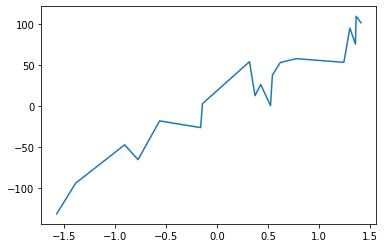

In [16]:
plt.plot(X_test,y_test)

In [17]:
# 保存数据
raw_data = (X_train, X_test, y_train, y_test)

In [19]:
import pickle
pkl_file = open('datas/linear_data.pkl', 'wb')
pickle.dump(raw_data, pkl_file)
pkl_file.close()

In [115]:
# import pickle
# pkl_file = open('datas/linear_data.pkl', 'rb')
# X_train, X_test, y_train, y_test = pickle.load(pkl_file)

<br><br>

## 线性回归

In [20]:
class Regression(object):
    
    """
        基础线性回归模型，使用输入的X和y进行参数回归
        超参：
        n_iterations:int 训练的步数，迭代多少次
        learning_rate:float 学习率
        
        内部函数:
        initialize_weights:初始化参数
        fit:开始训练
        predict:预测
        
        内部的数据:
        n_iterations
        learning_rate
        regularization:正则化参数
        regularization.grad:正则化的梯度函数
    """
    
    def __init__(self, n_iterations, learning_rate):
        self.n_iterations=n_iterations
        self.learning_rate=learning_rate
        self.regularization=lambda x:0
        self.regularization.grad=lambda x:0
    
    def initialize_weights(self, n_features):
        """初始化系数，输入是feature的个数，输出是一个随机初始化好的参数矩阵,[-1/sqrt(N),1/sqrt(N)]"""
        # 实验得出经典算法，随机分布初始化系数
        limit=1/math.sqrt(n_features)
        self.w=np.random.uniform(-limit,limit,(n_features,))
        #Uniform Distribution/Xavier/MSRA/Gaussian 高斯初始化
    
    def fit(self, X, y):
        #插入偏置列1到X中
        X = np.insert(X,0,1,axis=1)#给每一行的第0列增加一个1
        self.training_errors = []#保存每一次步长的训练Loss
        self.initialize_weights(n_features=X.shape[1])#初始化参数w
        
        #进行梯度下降迭代
        for i in range(self.n_iterations):
            y_pred=X.dot(self.w)#进行预测
            #计算Loss
            mse=np.mean(0.5*(y-y_pred)**2+self.regularization(self.w))
            self.training_errors.append(mse)#将Loss加入到training_errors的数组中
            #计算带有正则化项的梯度
            g_w=-(y-y_pred).T.dot(X)/len(X)+self.regularization.grad(self.w)
            #根据梯度下降的算法更新参数
            self.w-=self.learning_rate*g_w
            
    def predict(self,X):
        #通过输入X预测一个样本
        X=np.insert(X,0,1,axis=1)
        pred=X.dot(self.w)
        return pred
    

In [21]:
model=Regression(n_iterations=1000, learning_rate=0.01)

In [22]:
model.fit(X_train,y_train)

In [23]:
# model.training_errors

### 打印training_errors值

Text(0.5, 0, 'Steps')

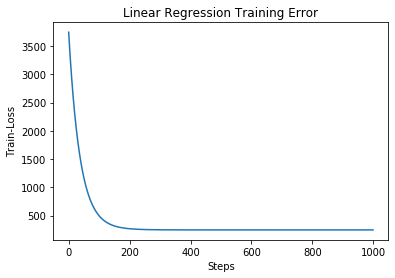

In [24]:
training,=plt.plot(range(len(model.training_errors)), model.training_errors,label="Training Error")
plt.title("Linear Regression Training Error")
plt.ylabel("Train-Loss")
plt.xlabel("Steps")

In [25]:
model.w

array([-2.42815335, 72.61965759])

### 评价模型

In [26]:
y_pred=model.predict(X_test)

In [27]:
mse=mean_squared_error(y_pred,y_test)

In [28]:
mse

311.85783724440796

In [29]:
import warnings
warnings.filterwarnings("ignore")

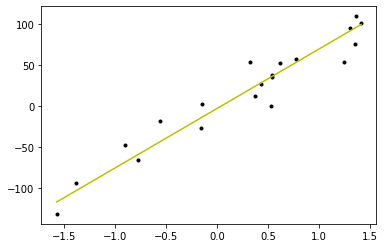

In [30]:
plt.plot(X_test,y_test,'k.')
plt.plot(X_test,y_pred,'Y')

<br><br>

## 带有最小二乘法的线性回归

In [31]:
def lsm_function(X,y):
    G=np.mat(np.insert(X,0,1,axis=1))
    # squeeze 二维矩阵 -> 把它降成一维二元的矩阵np数组
    # return np.asarray((G.T.dot(G)).I.dot(G.T).dot(y))
    return np.squeeze(np.asarray((G.T.dot(G)).I.dot(G.T).dot(y)))

In [32]:
lsm_function(X_train,y_train)

array([-2.42561025, 72.62091006])

In [33]:
lsm_function(X_train,y_train)

array([-2.42561025, 72.62091006])

In [34]:
class LinearRegression(Regression):
    """带有最小二乘法的线性回归
    参数:
    -------------
    n_iterations
    
    learning_rate
    
    gradient_descent:bool 
        决定是否使用梯度下降法，如果是True则使用梯度下降，False使用最小二乘
    """
    def __init__(self, n_iterations=500, learning_rate=0.1, gradient_descent=True):
        self.gradient_descent=gradient_descent
        self.regularization=lambda x:0
        self.regularization.grad=lambda x:0
        super(LinearRegression,self).__init__(n_iterations=n_iterations,learning_rate=learning_rate)
    
    def fit(self,X,y):
        if not self.gradient_descent:
            self.w=lsm_function(X,y)
        else:
            super(LinearRegression,self).fit(X,y)
    
    def predict(self,X):
        return super(LinearRegression,self).predict(X)
        

In [35]:
model=LinearRegression(n_iterations=1000, learning_rate=0.1, gradient_descent=False)

In [36]:
model.fit(X_train,y_train)

In [37]:
model.w

array([-2.42561025, 72.62091006])

In [38]:
def test_and_draw(model):
    y_pred=model.predict(X_test)
    mse=mean_squared_error(y_test,y_pred)
    print("方差:",mse)
    plt.plot(X_test,y_test,'k.')
    plt.plot(X_test,y_pred,'Y')

方差: 311.86402927010636


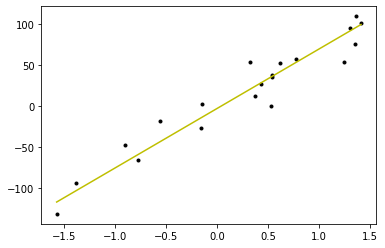

In [39]:
test_and_draw(model)

<br><br>

## 正则化回归

正则化的 loss

正则化的 grad梯度

In [40]:
w=[-3, 4]
np.linalg.norm(w, ord=1)

7.0

In [41]:
np.linalg.norm(w, ord=2)

5.0

### L2正则化参数

In [42]:
class l1_regularization():
    """L1正则化类/函数
    参数:
    
    alpha--L1正则化系数
    """
    def __init__(self, alpha):
        self.alpha=alpha
    def __call__(self,w):
        return self.alpha*np.linalg.norm(w,ord=1)
    def grad(self,w):
        #w>0->w`=1;w<0->w`=0;w==0->w`=0
        return self.alpha*np.sign(w)

In [43]:
l1=l1_regularization(alpha=0.01)

In [44]:
l1([-3,4])

0.07

In [45]:
l1.grad([-3,4,0])

array([-0.01,  0.01,  0.  ])

### L2正则化参数

In [46]:
class l2_regularization():
    """L2正则化参数
    参数：
    
    alpha 正则化系数
    """
    def __init__(self,alpha):
        self.alpha=alpha
    
    def __call__(self,w):
        return self.alpha*0.5*w.T.dot(w)
    
    def grad(self,w):
        return self.alpha*w

<br><br>

### LassoLinearRegression

In [47]:
class LassoLinearRegression(Regression):
    def __init__(self,alpha,n_iterations=1000,learning_rate=0.01):
        self.regularization=l1_regularization(alpha=alpha)
        super(LassoLinearRegression,self).__init__(n_iterations,learning_rate)
        
    def fit(self,X,y):
        super(LassoLinearRegression,self).fit(X,y)
    def predict(self,X):
        return super(LassoLinearRegression,self).predict(X)

In [48]:
model=LassoLinearRegression(alpha=120, n_iterations=1000,learning_rate=0.1)

In [49]:
model.fit(X_train,y_train)

In [50]:
model.w

array([-2.42561025, 72.62091006])

方差: 311.8640292701059


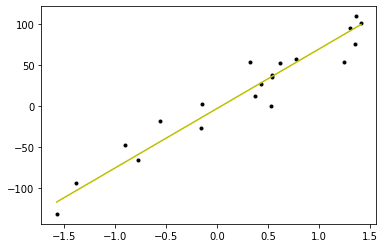

In [51]:
test_and_draw(model)

<br><br>

### RidgeLinearRegression

In [52]:
class RidgeLinearRegression(Regression):
    def __init__(self,alpha,n_iterations=1000,learning_rate=0.01):
        self.regularization = l2_regularization(alpha=alpha)
        super(RidgeLinearRegression, self).__init__(n_iterations, learning_rate)
        
    def fit(self,X,y):
        super(RidgeLinearRegression, self).fit(X, y)
    def predict(self,X):
        return super(RidgeLinearRegression,self).predict(X)

In [53]:
model=RidgeLinearRegression(alpha=120,n_iterations=1000,learning_rate=0.1)

In [54]:
model.fit(X_train,y_train)

In [55]:
model.w

array([-2.42561025, 72.62091006])

方差: 311.8640292701059


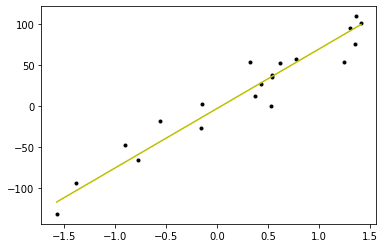

In [56]:
test_and_draw(model)

<br><br>

### L1，L2调和的正则化

在调和的正则化中，

l1_ratio:调和时，L1正则化的值所占的百分比[0,1]

\_l2_ratio= 1 - l1_ratio(事实上在算法中也找不到l2_ratio)

alpha:全局的整体的正则化权重

Loss = mse + alpha * (l1\_ratio * L1Loss + (1-l1\_ratio) * L2Loss)

In [57]:
class l1_l2_regularization():
    """使用在ElasticNet中的正则化"""
    
    def __init__(self,alpha,l1_ratio=0.5):
        self.alpha=alpha
        self.l1_ratio=l1_ratio
    
    def __call__(self,w):
        l1_loss=self.l1_ratio*np.linalg.norm(w,ord=1)
        l2_loss=(1-self.l1_ratio)*0.5*w.T.dot(w) #np.linalg.norm(w,ord=2)**2
        return self.alpha*(l1_loss+l2_loss)
    def grad(self,w):
        l1_grad=self.l1_ratio*np.sign(w)
        l2_grad=(1-self.l1_ratio)*w
        return self.alpha*(l1_grad+l2_grad)
        

In [58]:
l1_l2=l1_l2_regularization(alpha=0.1)

In [59]:
l1_l2(np.array([3,4]))

0.9750000000000001

In [60]:
l1_l2.grad(np.array([3,4]))

array([0.2 , 0.25])

In [61]:
0.5*np.sign(np.array([3,4]))

array([0.5, 0.5])

In [62]:
0.5*np.array([3,4])

array([1.5, 2. ])

### ElasticNetLinearRegression

In [63]:
class ElasticNetLinearRegression(Regression):
    """
    ElasticNet线性回归算法
    ----------------------
    alpha:全局正则化参数
    l1_ratio:L1正则化参数比例
    n_iterations
    learning_rate
    """
    def __init__(self,alpha=0.05,l1_ratio=0.5,n_iterations=3000,learning_rate=0.01):
        self.regularization=l1_l2_regularization(alpha=alpha,l1_ratio=l1_ratio)
        super(ElasticNetLinearRegression,self).__init__(n_iterations,learning_rate)
    def fit(self,X,y):
        super(ElasticNetLinearRegression,self).fit(X,y)
    def predict(self,X):
        return super(ElasticNetLinearRegression,self).predict(X)

In [64]:
model=ElasticNetLinearRegression(l1_ratio=0.5,alpha=1.2)

In [65]:
model.fit(X_train,y_train)

方差: 311.86402927004417


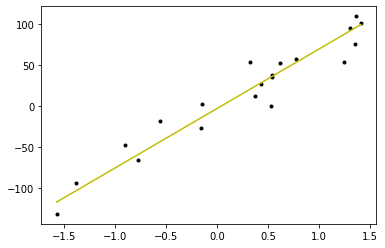

In [66]:
test_and_draw(model)